## Earthquake Magnitude Scale 

[https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/](https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/)

| Magnitude     | Earthquake Effects                                                               | Estimated Number Each Year |
|---------------|----------------------------------------------------------------------------------|-----------------------------|
| 2.5 or less   | Usually not felt, but can be recorded by seismograph.                             | Millions                    |
| 2.5 to 5.4    | Often felt, but only causes minor damage.                                        | 500,000                     |
| 5.5 to 6.0    | Slight damage to buildings and other structures.                                 | 350                         |
| 6.1 to 6.9    | May cause a lot of damage in very populated areas.                               | 100                         |
| 7.0 to 7.9    | Major earthquake. Serious damage.                                                | 10-15                       |
| 8.0 or greater| Great earthquake. Can totally destroy communities near the epicenter.           | One every year or two       |



## Earthquake Data

[https://earthquake.usgs.gov/earthquakes/search/](https://earthquake.usgs.gov/earthquakes/search/)

In [6]:
from requests import get

url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-03-12%2000%3A00%3A00&endtime=2023-04-12%2023%3A59%3A59&maxlatitude=90&minlatitude=-90&maxlongitude=180&minlongitude=-180&minmagnitude=4&orderby=time"
response = get(url)

if response.status_code == 200:
    response = response.json()
    features = response['features']
    print("\nSuccess!\n")
    print(f'{len(features)} earthquakes found.\n')


Success!

1243 earthquakes found.



In [7]:
from datetime import datetime
from urllib import parse
from tabulate import tabulate

urlParams = dict({
    'startTime': 'starttime',
    'endTime': 'endtime',
    'maxLatitude': 'maxlatitude',
    'minLatitude': 'minlatitude',
    'maxLongitude': 'maxlongitude',
    'minLongitude': 'minlongitude',
    'minMagnitude': 'minmagnitude',
    'orderBy': 'orderby'
})

def parse_url_segment(url, delimiter):
    return parse.unquote(url.split(delimiter)[1].split("&")[0])


def parse_url(url):
    obj = dict(urlParams)

    for key in obj:
        obj[key] = parse_url_segment(url, obj[key] + "=")

        if (key == 'startTime' or key == 'endTime'):
            obj[key] = datetime.strptime(obj[key], "%Y-%m-%d %H:%M:%S")

        if (key == 'maxLatitude' or key == 'minLatitude' or key == 'maxLongitude' or key == 'minLongitude' or key == 'minMagnitude'):
            obj[key] = float(obj[key])

    return obj

def create_table_from_params(urlParams): 
    table = []
    for key, value in urlParams.items():
        if isinstance(value, datetime):
            value = value.strftime('%Y-%m-%d %H:%M:%S')
        else:
            value = str(value)
        table.append((key, value))
    return tabulate(table, headers=['Parameter', 'Value'], tablefmt='grid')

urlParams = parse_url(url)
table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 2023-03-12 00:00:00 |
+--------------+---------------------+
| endTime      | 2023-04-12 23:59:59 |
+--------------+---------------------+
| maxLatitude  | 90.0                |
+--------------+---------------------+
| minLatitude  | -90.0               |
+--------------+---------------------+
| maxLongitude | 180.0               |
+--------------+---------------------+
| minLongitude | -180.0              |
+--------------+---------------------+
| minMagnitude | 4.0                 |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [8]:
# input
YEARS_TO_COLLECT = 75
MIN_MAGNITUDE = 4
FILE_NAME = 'earthquakes' # without extension

In [9]:
from datetime import timedelta

urlParams['minMagnitude'] = MIN_MAGNITUDE
urlParams['endTime'] = datetime.now()
urlParams['startTime'] = urlParams['endTime'] - \
    timedelta(weeks=YEARS_TO_COLLECT*52)

table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 1948-12-12 18:55:24 |
+--------------+---------------------+
| endTime      | 2023-09-10 18:55:24 |
+--------------+---------------------+
| maxLatitude  | 90.0                |
+--------------+---------------------+
| minLatitude  | -90.0               |
+--------------+---------------------+
| maxLongitude | 180.0               |
+--------------+---------------------+
| minLongitude | -180.0              |
+--------------+---------------------+
| minMagnitude | 4                   |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [12]:

import pandas as pd

df = pd.DataFrame(columns=['magnitude',
                  'time', 'latitude', 'longitude', 'depth'])


def append_earthquakes_to_dataframe(features):
    for earthquake in features:
        magnitude = earthquake['properties']['mag']
        time = earthquake['properties']['time']
        latitude = earthquake['geometry']['coordinates'][1]
        longitude = earthquake['geometry']['coordinates'][0]
        depth = earthquake['geometry']['coordinates'][2]

        df.loc[len(df)] = [magnitude, time, latitude, longitude, depth]


def get_earthquake_data(urlParams: dict[urlParams]):
    timeStep = timedelta(seconds=(urlParams['endTime'] - urlParams['startTime']).total_seconds() / 100)
    stepParams = dict(urlParams)
    while True:
        stepParams['startTime'] = stepParams['endTime'] - timeStep

        url = f"https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime={stepParams['startTime']}&endtime={stepParams['endTime']}&maxlatitude={stepParams['maxLatitude']}&minlatitude={stepParams['minLatitude']}&maxlongitude={stepParams['maxLongitude']}&minlongitude={stepParams['minLongitude']}&minmagnitude={stepParams['minMagnitude']}&orderby={stepParams['orderBy']}"
        response = get(url)

        if response.status_code == 400 and "matching events exceeds search limit" in response.text:
            print('search limit reached, timestep reduced')
            timeStep = timedelta(seconds=timeStep.total_seconds() / 2)
            continue

        if response.status_code != 200:
            print("Error: ", response.status_code)
            print(response.text)
            break

        append_earthquakes_to_dataframe(response.json()['features'])

        stepParams['endTime'] = stepParams['startTime']
        if (stepParams['endTime'] < urlParams['startTime']):
            break


get_earthquake_data(urlParams)

df.to_csv(FILE_NAME + '.csv')
print(f'\n{len(df)} earthquakes successfully exported to `{FILE_NAME}.csv.`')


490812 earthquakes successfully exported to `earthquakes.csv.`


In [1]:
IMPORT_FILE_NAME = 'earthquakes' # without extension

In [2]:
import pandas as pd

df = pd.read_csv(IMPORT_FILE_NAME + '.csv', index_col=0)

# convert time column to datetime
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

In [4]:
# input
PROFILE_REPORT_FILENAME = 'profile_report' # don't include extension

In [16]:

import ydata_profiling as ydp

profile = ydp.ProfileReport(df)

profile.to_file(PROFILE_REPORT_FILENAME + '.html')

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

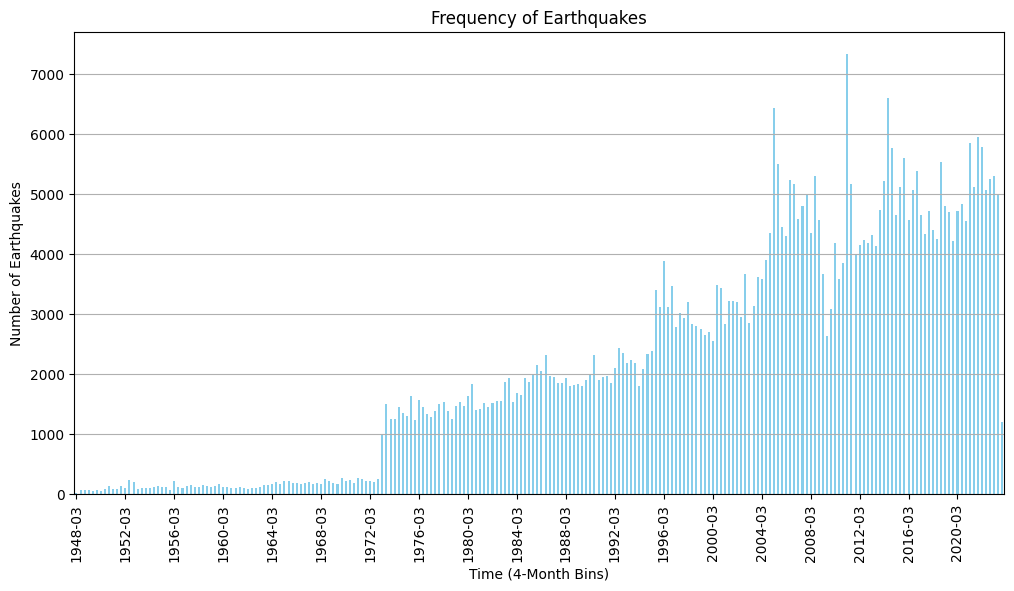

In [7]:
# earthquake frequency over time (histogram)
import matplotlib.pyplot as plt

# Set 'time' column as the index
freq = df.copy()
freq.set_index('datetime', inplace=True)

# Resample the data to 4-month frequency and count the number of earthquakes in each 4-month period
bins = freq.resample('4M').size()

# Create a bar plot
plt.figure(figsize=(12, 6))
bins.plot(kind='bar', color='skyblue')
plt.title('Frequency of Earthquakes')
plt.xlabel('Time (4-Month Bins)')
plt.ylabel('Number of Earthquakes')
plt.grid(axis='y')
# Set x-tick positions to show every 12th tick
x_tick_positions = range(0, len(bins), 12)
plt.xticks(x_tick_positions, bins.index[x_tick_positions].strftime('%Y-%m'))
plt.show()

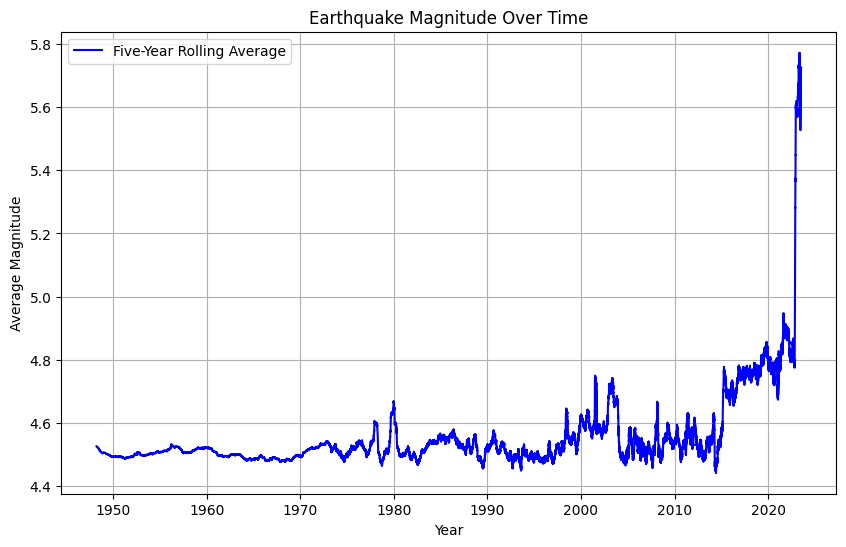

In [8]:
# earthquake magnitude over time (five year rolling average)
import matplotlib.pyplot as plt

# Sort the DataFrame by time
mag = df.copy()
mag = mag.sort_values(by='datetime')

# Calculate the one year rolling average of 'magnitude'
rolling_average = mag['magnitude'].rolling(window=365*5).mean()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], rolling_average, label='Five-Year Rolling Average', color='blue')
plt.xlabel('Year')
plt.ylabel('Average Magnitude')
plt.title('Earthquake Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()

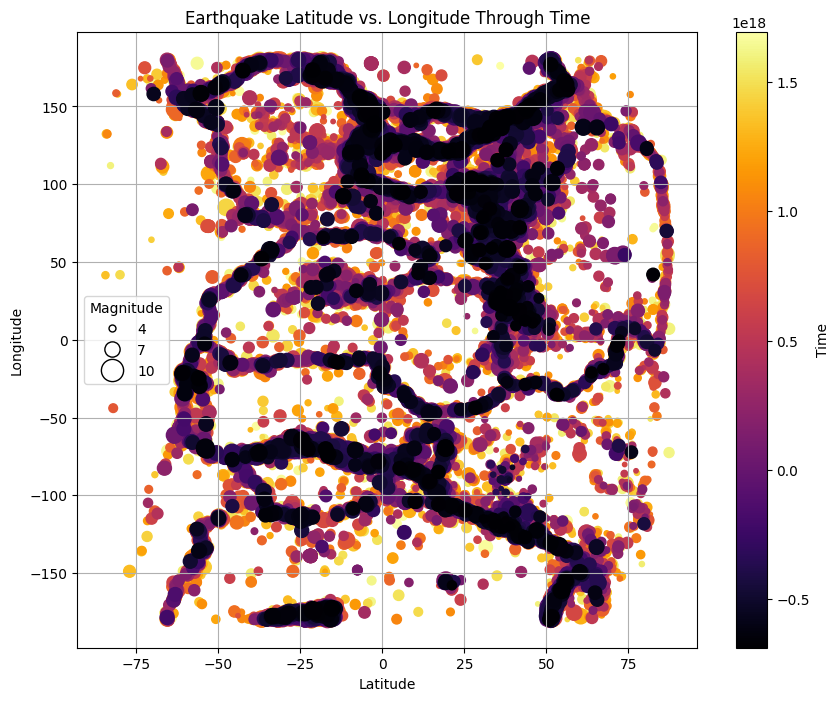

In [39]:
# earthquake location over time
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

loc = df.copy()
loc.sort_values(by='datetime', ascending=False)

# scale the 'magnitude' values to determine marker sizes
def get_marker_size(magnitude: float):
    min_magnitude = 4
    max_magnitude = 10  
    return 10 + 250 * (magnitude - min_magnitude) / (max_magnitude - min_magnitude)

marker_sizes = get_marker_size(loc['magnitude'])

# create marker size legend
def get_marker_legend_element(markersize: int, label: str):
    return plt.Line2D([0], [0], marker='o', color='k', markerfacecolor='w', markersize=markersize, label=label, linestyle='None')

legend_elements = [
    get_marker_legend_element(markersize=5, label='4'),
    get_marker_legend_element(markersize=11, label='7'),
    get_marker_legend_element(markersize=16, label='10')
]

plt.figure(figsize=(10, 8))
plt.scatter(loc['latitude'], loc['longitude'], c=loc['datetime'], cmap='inferno', s=marker_sizes)
plt.colorbar(label='Time')
plt.legend(handles=legend_elements, loc='center left', title='Magnitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Earthquake Latitude vs. Longitude Through Time')
plt.grid(True)
plt.show()